In [1]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, 
    "context_length": 1024, # number of tokens in a single input
    "emb_dim": 768, # same for both input and output
    "n_heads": 12, 
    "n_layers": 12, # number of transformer layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        ) # transfomer blocks
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # layer norm
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx): # input indices, like token IDs
        batch_size, seq_len = in_inx.shape # here seq_len is likely the input context length (1024)
        token_embs = self.token_emb(in_idx) # convert token IDs to token embeddings
        pos_embs = self.pos_emb(torch.arange(seq_len, device= in_idx.device))
        x = token_embs + pos_embs

        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x) 
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x


In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
# implemnting the idea of layer normalization
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out, out.shape)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>) torch.Size([2, 6])


In [5]:
mean = out.mean(dim=-1, keepdim=True) # keepdim has to be set to true in order to subtract it from the actual outputs
var = out.var(dim=-1, keepdim=True)
print("Mean: ", mean)
print("Variance: ", var)

Mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [6]:
out_norm = (out - mean)/ torch.sqrt(var) # element-wise subtraction and division
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [7]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x): # apply layer normalization followed by scale + shift
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)

        x_norm = (x - mean)/torch.sqrt(var + self.eps) # added self.eps to avoid ÷ 0
        return self.scale * x_norm + self.shift



In [9]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example) # the layer norm itself doesn't change the shape of it's input, it just normalizes it

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", out_ln)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.4945,  0.9564, -0.0200,  0.2375, -1.6685],
        [ 0.8127, -1.2313, -0.8554,  1.0110,  0.2630]], grad_fn=<AddBackward0>)
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/ torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


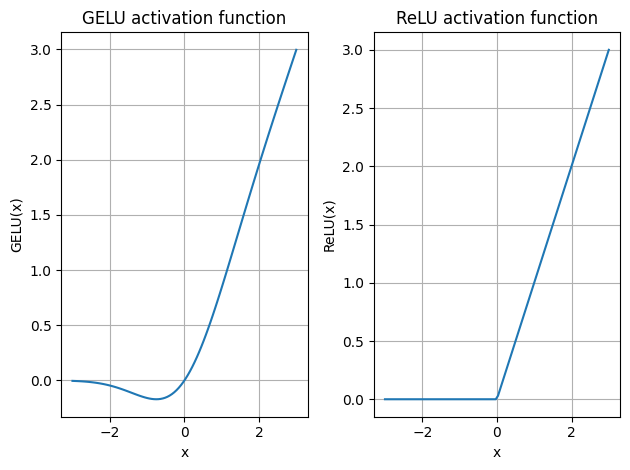

In [11]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU() # initialize instances

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1): # start enumeration at 1, not zero
    plt.subplot(1,2, i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
class FeedForward(nn.Module): # just two layers of weights
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), 
            GELU(), 
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)



In [13]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) # batch size: 2, three input tokens in each batch, and embedding size: 768
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [14]:
class ExampleDNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape: # also check whether we can add input and output, only then apply the skip connection
                x = x + layer_output # add the output of the function to the input to get the layer output
            else:
                x = layer_output
        return x


In [15]:
class ExampleDNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape: # also check whether we can add input and output, only then apply the skip connection
                x = x + layer_output # add the output of the function to the input to get the layer output
            else:
                x = layer_output
        return x


In [16]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDNN(layer_sizes, use_shortcut=False) # whenever we initialize a module, we use a 
# manual seed for reproducibility

In [17]:
def print_gradients(model, x): # prints the mean absolute gradients for each layer the NN model
    y = model(x)
    t = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss_value = loss(y, t)

    loss_value.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
        

In [18]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [19]:
torch.manual_seed(123)
model_with_shortcut = ExampleDNN(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [20]:
from attention2 import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], 
            d_out=cfg["emb_dim"], 
            context_length = cfg["context_length"], 
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"], 
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        shortcut = x
        x = self.norm1(x) # apply layernorm
        x = self.att(x)
        x = self.drop_shortcut(x) 
        x = x + shortcut # add the shortcut connection

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.4306, 1.4551])
keys.shape torch.Size([6, 2])
values.s

In [21]:
torch.manual_seed(123)
x = torch.randn(2, 4, 768)
tfblock = TransformerBlock(GPT_CONFIG_124M)
output = tfblock(x)

print("Input shape: ", x.shape)
print("Output shape: ", output.shape)


Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


In [22]:
class GPTModel(nn.Module): # the final abstraction; this is the 124M model
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        ) # transfomer blocks
        self.final_norm = LayerNorm(cfg["emb_dim"]) # layer norm
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        # print(self.token_emb.shape, self.out_head.shape)

    def forward(self, in_idx): # input indices, like token IDs
        batch_size, seq_len = in_idx.shape # here seq_len is different for different inputs; and that's okay
        # as long as it is less than the context_length 1024
        token_embs = self.token_emb(in_idx) # convert token IDs to token embeddings
        pos_embs = self.pos_emb(torch.arange(seq_len, device= in_idx.device)) # perform the lookups for positional embeddings
        x = token_embs + pos_embs

        x = self.drop_emb(x) # why do we apply dropout here? before even starting the transformer block?
        x = self.trf_blocks(x)
        x = self.final_norm(x) 
        logits = self.out_head(x)
        return logits


In [23]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

print("Input shape: ", batch.shape)
print("Output shape: ", out.shape)

Input shape:  torch.Size([2, 4])
Output shape:  torch.Size([2, 4, 50257])


In [24]:
total_params = sum([p.numel() for p in model.parameters()])
print(f"Total number of paramters: {total_params:,}")

Total number of paramters: 163,009,536


In [25]:
print("Token embedding layer shape: ", model.token_emb.weight.shape)
print("Output layer shape: ", model.out_head.weight.shape)
# given (in, out) shape, nn.Embedding stores it as it is, but nn.Linear stores it transposed, hence the outputs have 
# the same shape: 50k * 768: That's a lot of parameters!

Token embedding layer shape:  torch.Size([50257, 768])
Output layer shape:  torch.Size([50257, 768])


In [26]:
total_params_gpt2 = total_params - sum([p.numel() for p in model.out_head.parameters()])
print(f"Total number of paramters in GPT 2: {total_params_gpt2:,}")

Total number of paramters in GPT 2: 124,412,160


In [27]:
attn_params = sum([p.numel() for p in model.trf_blocks[0].att.parameters()])*12
ff_params = sum([p.numel() for p in model.trf_blocks[1].ff.parameters()])*12

print(f"Attention paramters in GPT 2: {attn_params:,}")
print(f"Feed forward neural network paramters in GPT 2: {ff_params:,}")

Attention paramters in GPT 2: 28,320,768
Feed forward neural network paramters in GPT 2: 56,669,184


In [28]:
total_size_bytes = total_params * 4 # assuming four bytes for each paramter; float32
total_size_mb = total_size_bytes / (1024*1024)
print(f"Total size in bytes: {total_size_mb:.2f} MB")

Total size in bytes: 621.83 MB


In [29]:
GPT2_MEDIUM_CONFIG = {
    "vocab_size" : 50257, 
    "context_length": 1024, # number of tokens in a single input
    "emb_dim": 1024, # same for both input and output
    "n_heads": 16, 
    "n_layers": 24, # number of transformer layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}
GPT2_LARGE_CONFIG = {
    "vocab_size" : 50257, 
    "context_length": 1024, # number of tokens in a single input
    "emb_dim": 1280, # same for both input and output
    "n_heads": 20, 
    "n_layers": 36, # number of transformer layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}
GPT2_XL_CONFIG = {
    "vocab_size" : 50257, 
    "context_length": 1024, # number of tokens in a single input
    "emb_dim": 1600, # same for both input and output
    "n_heads": 25, 
    "n_layers": 48, # number of transformer layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}
model_m = GPTModel(GPT2_MEDIUM_CONFIG)
model_l = GPTModel(GPT2_LARGE_CONFIG)
model_xl = GPTModel(GPT2_XL_CONFIG)

total_params_medium = sum([p.numel() for p in model_m.parameters()])
total_params_large = sum([p.numel() for p in model_l.parameters()])
total_params_xl = sum([p.numel() for p in model_xl.parameters()])

print(f"Total number of paramters in GPT 2 medium: {total_params_medium:,}")
print(f"Total number of paramters in GPT 2 large: {total_params_large:,}")
print(f"Total number of paramters in GPT 2 XL: {total_params_xl:,}")


Total number of paramters in GPT 2 medium: 406,212,608
Total number of paramters in GPT 2 large: 838,220,800
Total number of paramters in GPT 2 XL: 1,637,792,000


In [30]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx has shape (batch_size, num_tokens, 
    for _ in range(max_new_tokens):
        idx_context = idx[:, -context_size:] # if the input seq is longer than context_length, crop it from the end
        with torch.no_grad():
            logits = model(idx_context) # has shape (batch_size, num_tokens, vocab_size)
    
        logits = logits[:, -1, :] # extract the output of the very last token returned; shape (batch_size, vocab_size)
        probs = torch.softmax(logits, dim=-1) 
        idx_next = torch.argmax(probs, dim=-1, keepdim=True) # extract the token ID of that last vector; shape (batch_size, 1)
        idx = torch.cat((idx, idx_next), dim=1) # append the output to the old input; shape (batch_size, n_tokens+1)

    return idx

    

In [31]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context) # returns a list of encoded token IDs
print("Encoded list: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adds a new batch dimension at index 0 
print("encoded_tensor shape: ", encoded_tensor.shape)

Encoded list:  [15496, 11, 314, 716]
encoded_tensor shape:  torch.Size([1, 4])


In [32]:
model.eval()
out = generate_text_simple(
    model = model, 
    idx = encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output: ", out)
print("Length of output: ", out.shape[1])

Output:  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Length of output:  10


In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist()) # input to the decoder has to be passed as a list
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
